In [1]:
import pandas as pd
import qiime2 as q2
from biom import Table
import numpy as np
from biom.util import biom_open

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# import metabolomics subsets

In [23]:
metab_metadata = pd.read_csv('../data/metabolomics/BEAM_metadata_KAW.csv', index_col='Sample.Barcode')

#metab_metadata = metab_metadata[~metab_metadata.SubjectID.isin(['3JEBA000908'])]
metab_metadata.index = metab_metadata.index.astype(str)
metab_metadata = metab_metadata[metab_metadata['First.Diet'].isin(['1','2'])]
metab_metadata['First.Diet'] = metab_metadata['First.Diet'].astype(int)

metab_metadata['diet_nocross'] = metab_metadata['Diet.Type.Detailed'].replace({'Keto-to-AHA Crossover':'AHA Diet', 'AHA-to-Keto Crossover':'Ketogenic Diet'})
metab_metadata['timepoint_encoded'] = metab_metadata['Study_TP']
metab_metadata['first_diet'] = metab_metadata['First.Diet']

metab_metadata_stool = metab_metadata[metab_metadata['Sample.Type'] == 'Stool']

metab_metadata.head(5)


,Sample.Type,SubjectID,StudyID,Status,First.Diet,Age,Gender,BMI_pbl,MemDx,Visit.Type.Stool,...,StudyID_1,Visit.Type.Blood,Cog.Visit.Date,Diet.Type.Detailed,Visit.Type.Detailed,Study_TP,filename,diet_nocross,timepoint_encoded,first_diet
Sample.Barcode,,,,,,,,,,,,,,,,,,,,,
5555659,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,Pre 1,...,1263001,PREA-COG,02/04/2015,Ketogenic Diet,Ketogenic Diet Preliminary,1,5555659.mzXML,Ketogenic Diet,1,1
5555660,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,Post 1,...,1263001,POSTA-COG,3/24/2015,Ketogenic Diet,Ketogenic Diet Post-Diet,2,5555660.mzXML,Ketogenic Diet,2,1
5555661,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,FU 1 / Pre 2,...,1263001,PREB-COG,05/05/2015,Keto-to-AHA Crossover,Ketogenic 6-Week Follow-up & AHA Diet Preliminary,3,5555661.mzXML,AHA Diet,3,1
5555662,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,Post 2,...,1263001,POSTB-COG,6/17/2015,AHA Diet,AHA Diet Post-Diet,4,5555662.mzXML,AHA Diet,4,1
5555663,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,FU 2,...,1263001,POSTB-FU,08/03/2015,AHA Diet,AHA 6-Week Follow-up Only,5,5555663.mzXML,AHA Diet,5,1


In [24]:
metab_metadata.shape

(297, 24)

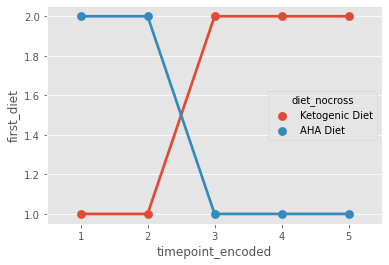

In [25]:
sns.pointplot(y='first_diet', x='timepoint_encoded', hue='diet_nocross', data=metab_metadata)

plt.show()


# match the microbiome data

In [37]:
metadata = pd.read_csv('../data/13662_20210620-201815.txt', sep='\t', index_col=0)

# drop one timepoint subject
#metadata = metadata[~metadata.host_subject_id.isin(['3JEBA000908'])]

# drop the dropout subjects
metadata = metadata[metadata['first_diet'].isin(['1','2'])]
metadata['first_diet'] = metadata['first_diet'].astype(int)

# fix and clean data 
metadata = metadata[metadata.host_body_habitat == 'UBERON:feces'] # drop blank
metadata['cog'] = metadata.memdx.replace({'NC-SC':'NC','MCI-A':'MCI','MCI-MDA':'MCI'}) # merge cogs
metadata['timepoint'] = metadata.timepoint.replace({'FU 2 /Pre 1':'FU 2 / Pre 1'}) # fix typo

# add diet from metabolomics data by barcode
diet_map = metab_metadata['Diet.Type.Detailed'].to_dict()
metadata['diet'] = [diet_map[ind.replace('13662.','')] for ind in metadata.index]
metadata['diet_nocross'] = metadata.diet.replace({'Keto-to-AHA Crossover':'AHA Diet', 'AHA-to-Keto Crossover':'Ketogenic Diet'})

#get timepoint map from metabolomics (comes from "BEAM Diet Guide.doc")
timepoint_map =  metab_metadata['Study_TP'].to_dict()
metadata['timepoint_encoded'] = [int(timepoint_map[ind.replace('13662.','')]) for ind in metadata.index]


metadata.head(5)


,age,anonymized_name,bmi_pbl,box_name,cog_visit_date,collection_timestamp,description,dna_extracted,elevation,empo_1,...,taxon_id,timepoint,title,tube_id,uom,visit_type,cog,diet,diet_nocross,timepoint_encoded
sample_name,,,,,,,,,,,,,,,,,,,,,
13662.5555659,62,1263001,27.92,31102 Stool Box 1,2/4/15,2015-02-11,fecal sample Pre 1 3AWFR000081,True,300,Host-associated,...,408170,Pre 1,BEAM_U19,0005555659,mg,PreA-Cog,MCI,Ketogenic Diet,Ketogenic Diet,1
13662.5555660,62,1263001,27.92,31102 Stool Box 1,3/24/15,2015-03-25,fecal sample Post 1 3AWFR000081,True,300,Host-associated,...,408170,Post 1,BEAM_U19,0005555660,mg,POSTA-COG,MCI,Ketogenic Diet,Ketogenic Diet,2
13662.5555661,62,1263001,27.92,31102 Stool Box 1,5/5/15,2015-05-07,fecal sample FU 1 / Pre 2 3AWFR000081,True,300,Host-associated,...,408170,FU 1 / Pre 2,BEAM_U19,0005555661,mg,PREB-COG,MCI,Keto-to-AHA Crossover,AHA Diet,3
13662.5555662,62,1263001,27.92,31102 Stool Box 1,6/17/15,2015-06-22,fecal sample Post 2 3AWFR000081,True,300,Host-associated,...,408170,Post 2,BEAM_U19,0005555662,mg,POSTB-COG,MCI,AHA Diet,AHA Diet,4
13662.5555663,62,1263001,27.92,31102 Stool Box 1,8/3/15,2015-08-04,fecal sample FU 2 3AWFR000081,True,300,Host-associated,...,408170,FU 2,BEAM_U19,0005555663,mg,POSTB-FU,MCI,AHA Diet,AHA Diet,5


In [38]:
metadata.shape

(99, 63)

In [50]:
# import 16S
bt = q2.Artifact.load('../data/metaG/144625_feature-table.qza').view(Table)

# match the metadata 
shared_samples = set(bt.ids()) & set(metadata.index)
metadata_metag = metadata.copy().reindex(shared_samples)

# filte table
bt = bt.filter(shared_samples)

# filter and match the table
n_features, n_samples = bt.shape
min_feature_frequency = 0
min_feature_count = 0
min_sample_count = 0
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
bt = bt.filter(observation_filter, axis='observation')
bt = bt.filter(frequency_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > min_sample_count)])

table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
table.save('../data/metaG/metaG-matched-table.qza')

with biom_open('../data/metaG/metaG-matched-table.biom', 'w') as f:
    table.view(Table).to_hdf5(f, "filt")

metadata_metag.to_csv('../data/metaG/metaG-matched-metadata.tsv', sep='\t')

metadata_metag.index = metadata_metag.index.astype(str)
metadata_metag = metadata_metag.drop(['dna_extracted','physical_specimen_remaining'], axis=1)
q2.Metadata(metadata_metag).save('../data/metaG/metaG-matched-metadata.qza')

bt


5661 x 94 <class 'biom.table.Table'> with 178208 nonzero entries (33% dense)

In [44]:
5e5

500000.0

In [31]:
pd.DataFrame({t:tdf.cog.value_counts() for t, tdf in metadata_metag.groupby(['timepoint_encoded','diet'])}).T

MCI  NC
1 AHA Diet                 2   5
  Ketogenic Diet           6   7
2 AHA Diet                 2   5
  Ketogenic Diet           6   6
3 AHA-to-Keto Crossover    3   5
  Keto-to-AHA Crossover    6   6
4 AHA Diet                 6   6
  Ketogenic Diet           2   5
5 AHA Diet                 6   5
  Ketogenic Diet           1   4

In [32]:
pd.DataFrame({t:tdf.diet.value_counts() for t, tdf in metadata_metag.groupby(['host_subject_id'])}).T


,AHA Diet,AHA-to-Keto Crossover,Keto-to-AHA Crossover,Ketogenic Diet
3AWFR000081,2.0,NaN,1.0,2.0
3BCCR001024,2.0,NaN,1.0,2.0
3BLFO000040,2.0,NaN,1.0,2.0
3BSLA000746,2.0,1.0,NaN,2.0
3CBSH000827,2.0,1.0,NaN,2.0
3CDMA000951,2.0,1.0,NaN,1.0
3EHRI000773,2.0,NaN,1.0,2.0
3FHGO000392,2.0,1.0,NaN,2.0
3JACA001152,2.0,NaN,1.0,2.0
3JEBA000908,NaN,NaN,NaN,1.0


In [33]:
pd.DataFrame({t:tdf.first_diet.value_counts() for t, tdf in metadata_metag.groupby(['host_subject_id'])}).T


,1,2
3AWFR000081,5.0,NaN
3BCCR001024,5.0,NaN
3BLFO000040,5.0,NaN
3BSLA000746,NaN,5.0
3CBSH000827,NaN,5.0
3CDMA000951,NaN,4.0
3EHRI000773,5.0,NaN
3FHGO000392,NaN,5.0
3JACA001152,5.0,NaN
3JEBA000908,1.0,NaN


In [19]:
bt = q2.Artifact.load('../data/metaG/144625_feature-table.qza').view(Table)

bt

5715 x 103 <class 'biom.table.Table'> with 186866 nonzero entries (31% dense)

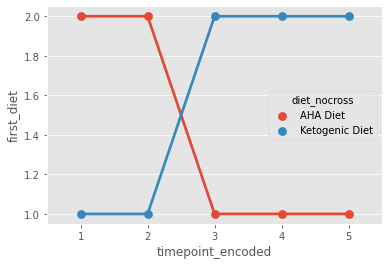

In [18]:
sns.pointplot(y='first_diet', x='timepoint_encoded', hue='diet_nocross', data=metadata_metag)

plt.show()


In [20]:
# import 16S
bt = q2.Artifact.load('../data/16S/120736_feature-table.qza').view(Table)

# match the metadata 
shared_samples = set(bt.ids()) & set(metadata.index)
metadata_16S = metadata.copy().reindex(shared_samples)

# filte table
bt = bt.filter(shared_samples)

# filter and match the table
n_features, n_samples = bt.shape
min_feature_frequency = 0
min_feature_count = 0
min_sample_count = 100
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
bt = bt.filter(observation_filter, axis='observation')
bt = bt.filter(frequency_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > min_sample_count)])

table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
table.save('../data/16S/16S-matched-table.qza')

with biom_open('../data/16S/16S-matched-table.biom', 'w') as f:
    table.view(Table).to_hdf5(f, "filt")

metadata_16S.to_csv('../data/16S/16S-matched-metadata.tsv', sep='\t')

metadata_16S.index = metadata_16S.index.astype(str)
metadata_16S = metadata_16S.drop(['dna_extracted','physical_specimen_remaining'], axis=1)
q2.Metadata(metadata_16S).save('../data/16S/16S-matched-metadata.qza')

bt


7397 x 96 <class 'biom.table.Table'> with 26944 nonzero entries (3% dense)

# make stool subset for mmvec that is matched for metabolomics

In [27]:
# import L4 and L5 tables and match them and save
fecal_l4 = pd.read_csv('../data/metabolomics/BEAM_fecal_food_counts_L4.csv', index_col=0)
fecal_l4.index = ['13662.' + x.replace('.mzXML', '') for x in fecal_l4.index]
fecal_l4_16S = fecal_l4.reindex(metadata_16S.index)
fecal_l4_metag = fecal_l4.reindex(metadata_metag.index)

fecal_l4_16S = q2.Artifact.import_data('FeatureTable[Frequency]',
                                       Table(fecal_l4_16S.values.T,
                                             fecal_l4_16S.columns,
                                             fecal_l4_16S.index))
fecal_l4_16S.save('../data/metabolomics/matched-table-L4-16S.qza')

fecal_l4_metag = q2.Artifact.import_data('FeatureTable[Frequency]',
                                       Table(fecal_l4_metag.values.T,
                                             fecal_l4_metag.columns,
                                             fecal_l4_metag.index))
fecal_l4_metag.save('../data/metabolomics/matched-table-L4-metaG.qza')


fecal_l5 = pd.read_csv('../data/metabolomics/BEAM_fecal_food_counts_L5.csv', index_col=0)
fecal_l5.index = ['13662.' + x.replace('.mzXML', '') for x in fecal_l5.index]
fecal_l5_16S = fecal_l5.reindex(metadata_16S.index)
fecal_l5_metag = fecal_l5.reindex(metadata_metag.index)

fecal_l5_16S = q2.Artifact.import_data('FeatureTable[Frequency]',
                                       Table(fecal_l5_16S.values.T,
                                             fecal_l5_16S.columns,
                                             fecal_l5_16S.index))
fecal_l5_16S.save('../data/metabolomics/matched-table-L5-16S.qza')

fecal_l5_metag = q2.Artifact.import_data('FeatureTable[Frequency]',
                                       Table(fecal_l5_metag.values.T,
                                             fecal_l5_metag.columns,
                                             fecal_l5_metag.index))
fecal_l5_metag.save('../data/metabolomics/matched-table-L5-metaG.qza')


fecal_metaball = pd.read_excel('../data/metabolomics/BEAM_FBMN2_quant.xlsx', index_col=0)
fecal_metaball = fecal_metaball.drop(['row m/z','row retention time'], axis=1)
fecal_metaball.columns = [x.split(' ')[0] for x in fecal_metaball.columns]
fecal_metaball = fecal_metaball.T
fecal_metaball.index = ['13662.' + x.replace('.mzXML', '') for x in fecal_metaball.index]
fecal_metaball_16S = fecal_metaball.reindex(metadata_16S.index)
fecal_metaball_metag = fecal_metaball.reindex(metadata_metag.index)
fecal_metaball_16S = fecal_metaball_16S.loc[:, fecal_metaball_16S.sum(0) > 0]
fecal_metaball_metag = fecal_metaball_metag.loc[:, fecal_metaball_metag.sum(0) > 0]
fecal_metaball_metag.columns = 'f' + fecal_metaball_metag.columns.astype(str)
fecal_metaball_16S.columns = 'f' + fecal_metaball_16S.columns.astype(str)

fecal_metaball_16S = q2.Artifact.import_data('FeatureTable[Frequency]',
                                       Table(fecal_metaball_16S.values.T,
                                             fecal_metaball_16S.columns,
                                             fecal_metaball_16S.index))
fecal_metaball_16S.save('../data/metabolomics/matched-table-metaball-16S.qza')

fecal_metaball_metag = q2.Artifact.import_data('FeatureTable[Frequency]',
                                       Table(fecal_metaball_metag.values.T,
                                             fecal_metaball_metag.columns,
                                             fecal_metaball_metag.index))
fecal_metaball_metag.save('../data/metabolomics/matched-table-metaball-metaG.qza')

# make copies for metadata
metab_metadata_stool_subset_16S = metab_metadata_stool.copy()
metab_metadata_stool_subset_metaG = metab_metadata_stool.copy()

# match index w Qiita id
metab_metadata_stool_subset_16S.index = '13662.' + metab_metadata_stool_subset_16S.index
metab_metadata_stool_subset_metaG.index = '13662.' + metab_metadata_stool_subset_metaG.index
# match to each
metab_metadata_stool_subset_16S = metab_metadata_stool_subset_16S.reindex(metadata_16S.index)
metab_metadata_stool_subset_metaG = metab_metadata_stool_subset_metaG.reindex(metadata_metag.index)
metab_metadata_stool_subset_16S.to_csv('../data/metabolomics/matched-metadata-16S.tsv', sep='\t')
metab_metadata_stool_subset_metaG.to_csv('../data/metabolomics/matched-metadata-metaG.tsv', sep='\t')


In [66]:
serum_metaball = pd.read_excel('../data/metabolomics/BEAM_FBMN2_quant.xlsx', index_col=0)
serum_metaball = serum_metaball.drop(['row m/z','row retention time'], axis=1)
#serum_metaball.columns = [x.split(' ')[0] for x in serum_metaball.columns]
serum_metaball = serum_metaball.T
#serum_metaball.index = ['13662.' + x.replace('.mzXML', '') for x in serum_metaball.index]


In [73]:
metab_metadata

,Sample.Type,SubjectID,StudyID,Status,First.Diet,Age,Gender,BMI_pbl,MemDx,Visit.Type.Stool,...,StudyID_1,Visit.Type.Blood,Cog.Visit.Date,Diet.Type.Detailed,Visit.Type.Detailed,Study_TP,filename,diet_nocross,timepoint_encoded,first_diet
Sample.Barcode,,,,,,,,,,,,,,,,,,,,,
5555659,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,Pre 1,...,1263001,PREA-COG,02/04/2015,Ketogenic Diet,Ketogenic Diet Preliminary,1,5555659.mzXML,Ketogenic Diet,1,1
5555660,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,Post 1,...,1263001,POSTA-COG,3/24/2015,Ketogenic Diet,Ketogenic Diet Post-Diet,2,5555660.mzXML,Ketogenic Diet,2,1
5555661,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,FU 1 / Pre 2,...,1263001,PREB-COG,05/05/2015,Keto-to-AHA Crossover,Ketogenic 6-Week Follow-up & AHA Diet Preliminary,3,5555661.mzXML,AHA Diet,3,1
5555662,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,Post 2,...,1263001,POSTB-COG,6/17/2015,AHA Diet,AHA Diet Post-Diet,4,5555662.mzXML,AHA Diet,4,1
5555663,Stool,3AWFR000081,1263001,1,1,62,1,27.92,MCI-A,FU 2,...,1263001,POSTB-FU,08/03/2015,AHA Diet,AHA 6-Week Follow-up Only,5,5555663.mzXML,AHA Diet,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4050196493,Serum,3RHHO001472,1263039,1,1,67,1,24.35,MCI,Pre 1,...,1263039,PreA-Cog,10/05/2016,Ketogenic Diet,Ketogenic Diet Preliminary,1,4050196493.mzXML,Ketogenic Diet,1,1
4050196505,Serum,3RHHO001472,1263039,1,1,67,1,24.35,MCI,Post 1,...,1263039,POSTA-COG,11/29/2016,Ketogenic Diet,Ketogenic Diet Post-Diet,2,4050196505.mzXML,Ketogenic Diet,2,1
4050196829,Serum,3RHHO001472,1263039,1,1,67,1,24.35,MCI,FU 1 / Pre 2,...,1263039,PREB-COG,01/09/2017,Keto-to-AHA Crossover,Ketogenic 6-Week Follow-up & AHA Diet Preliminary,3,4050196829.mzXML,AHA Diet,3,1


In [65]:
metab_metadata_serum.T

Sample.Barcode,4050195729,4050195741,4050195201,4050195213,4050195225,4050195683,4050195695,4050195816,4050195828,4050195840,...,4050202000,4050201820,4050195677,4050196852,4050196481,4050196493,4050196505,4050196829,4050196841,4050196853
Sample.Type,Serum,Serum,Serum,Serum,Serum,Serum,Serum,Serum,Serum,Serum,...,Serum,Serum,Serum,Serum,Serum,Serum,Serum,Serum,Serum,Serum
SubjectID,3AWFR000081,3AWFR000081,3AWFR000081,3AWFR000081,3AWFR000081,3JXAL000304,3JXAL000304,3JXAL000304,3JXAL000304,3JXAL000304,...,3RLSI001164,3RLSI001164,3RLSI001164,3RLSI001164,3RLSI001164,3RHHO001472,3RHHO001472,3RHHO001472,3RHHO001472,3RHHO001472
StudyID,1263001,1263001,1263001,1263001,1263001,1263002,1263002,1263002,1263002,1263002,...,1263034,1263034,1263034,1263034,1263034,1263039,1263039,1263039,1263039,1263039
Status,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
First.Diet,1,1,1,1,1,2,2,2,2,2,...,2,2,2,2,2,1,1,1,1,1
Age,62,62,62,62,62,62,62,62,62,62,...,70,70,70,70,70,67,67,67,67,67
Gender,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,1,1,1,1,1
BMI_pbl,27.92,27.92,27.92,27.92,27.92,21.62,21.62,21.62,21.62,21.62,...,31.28,31.28,31.28,31.28,31.28,24.35,24.35,24.35,24.35,24.35
MemDx,MCI-A,MCI-A,MCI-A,MCI-A,MCI-A,NC,NC,NC,NC,NC,...,MCI,MCI,MCI,MCI,MCI,MCI,MCI,MCI,MCI,MCI
Visit.Type.Stool,Pre 1,Post 1,FU 1 / Pre 2,Post 2,FU 2,Pre 2,Post 2,FU 2 / Pre 1,Post 1,FU 1,...,Pre 2,Post 2,FU 2 / Pre 1,Post 1,FU 1,Pre 1,Post 1,FU 1 / Pre 2,Post 2,FU 2


In [62]:
metab_metadata_serum = metab_metadata[metab_metadata['Sample.Type'] == 'Serum']
metab_metadata_serum['StudyID'] = metab_metadata_serum.StudyID.astype(str)
metadata_metag_match = metadata_metag.copy()

metab_metadata_serum['morgind'] = metab_metadata_serum.index
metadata_metag_match['borgind'] = metadata_metag_match.index
metab_metadata_serum_match = metab_metadata_serum.set_index(['StudyID','Study_TP'])
metadata_metag_match = metadata_metag_match.set_index(['anonymized_name' ,'timepoint_encoded'])
metab_metadata_serum_match = pd.concat([metab_metadata_serum_match, metadata_metag_match], axis=1).dropna(subset=['morgind'])
metab_metadata_serum_match_map = metab_metadata_serum_match.set_index('morgind')['borgind'].to_dict()





/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


{'4050195729': '13662.5555659',
 '4050195741': '13662.5555660',
 '4050195201': '13662.5555661',
 '4050195213': '13662.5555662',
 '4050195225': '13662.5555663',
 '4050195683': '13662.5556614',
 '4050195695': '13662.5556617',
 '4050195816': '13662.5556620',
 '4050195828': '13662.5556623',
 '4050195840': '13662.5556625',
 '4050195852': '13662.5556637',
 '4050195684': '13662.5556638',
 '4050195696': '13662.5556639',
 '4050201916': '13662.5556640',
 '4050201928': '13662.5556641',
 '4050201940': '13662.5556652',
 '4050202049': '13662.5556653',
 '4050202061': '13662.5556654',
 '4050202073': '13662.5556655',
 '4050202085': '13662.5556656',
 '4050202097': '13662.5556667',
 '4050195752': '13662.5556668',
 '4050195224': '13662.5556669',
 '4050195717': '13662.5556670',
 '4050203503': '13662.5556671',
 '4050203539': '13662.5556685',
 '4050203359': '13662.5556686',
 '4050203371': '13662.5556687',
 '4050203468': '13662.5556688',
 '4050203480': '13662.5556689',
 '4050203492': '13662.5556700',
 '405020

In [53]:
metadata_metag_match

,,age,bmi_pbl,box_name,cog_visit_date,collection_timestamp,description,elevation,empo_1,empo_2,empo_3,...,stool_position,taxon_id,timepoint,title,tube_id,uom,visit_type,cog,diet,diet_nocross
anonymized_name,timepoint_encoded,,,,,,,,,,,,,,,,,,,,,
1263001,2,62,27.92,31102 Stool Box 1,3/24/15,2015-03-25,fecal sample Post 1 3AWFR000081,300,Host-associated,Animal,Animal distal gut,...,2,408170,Post 1,BEAM_U19,0005555660,mg,POSTA-COG,MCI,Ketogenic Diet,Ketogenic Diet
1263024,3,60,21,31102 Stool Box 1,4/13/16,2016-04-18,fecal sample FU 1 / Pre 2 3BCCR001024,300,Host-associated,Animal,Animal distal gut,...,69,408170,FU 1 / Pre 2,BEAM_U19,0005556816,mg,PREB-COG,NC,Keto-to-AHA Crossover,AHA Diet
1263034,1,70,31.28,31102 Stool Box 2,4/22/16,2016-05-19,fecal sample Pre 2 3RLSI001164,300,Host-associated,Animal,Animal distal gut,...,12,408170,Pre 2,BEAM_U19,0005556892,mg,PREA-COG,MCI,AHA Diet,AHA Diet
1263019,4,57,30.26,31102 Stool Box 1,11/23/15,2015-11-24,fecal sample Post 2 3LDMO000125,300,Host-associated,Animal,Animal distal gut,...,50,408170,Post 2,BEAM_U19,0005556748,mg,POSTB-COG,MCI,AHA Diet,AHA Diet
1263028,1,62,34,31102 Stool Box 2,4/19/16,2016-04-26,fecal sample Pre 2 3JRWE000881,300,Host-associated,Animal,Animal distal gut,...,1,408170,Pre 2,BEAM_U19,0005556859,mg,PREA-COG,MCI,AHA Diet,AHA Diet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263032,4,65,32.06,31102 Stool Box 2,10/4/16,2016-10-04,fecal sample Post 1 3MRHA001153,300,Host-associated,Animal,Animal distal gut,...,11,408170,Post 1,BEAM_U19,0005556883,mg,POSTB-COG,MCI,Ketogenic Diet,Ketogenic Diet
1263007,1,64,26.6,31102 Stool Box 1,4/2/15,2015-04-08,fecal sample Pre 1 3BLFO000040,300,Host-associated,Animal,Animal distal gut,...,11,408170,Pre 1,BEAM_U19,0005556637,mg,PREA-COG,MCI,Ketogenic Diet,Ketogenic Diet
1263028,2,62,34,31102 Stool Box 2,6/15/16,2016-06-22,fecal sample Post 2 3JRWE000881,300,Host-associated,Animal,Animal distal gut,...,2,408170,Post 2,BEAM_U19,0005556860,mg,POSTA-COG,MCI,AHA Diet,AHA Diet


In [35]:
metab_metadata_serum['Study_TP'].value_counts()

4    20
3    20
2    20
1    20
5    18
Name: Study_TP, dtype: int64

,,age,bmi_pbl,box_name,cog_visit_date,collection_timestamp,description,elevation,empo_1,empo_2,empo_3,...,stool_position,taxon_id,timepoint,title,tube_id,uom,visit_type,cog,diet,diet_nocross
anonymized_name,timepoint_encoded,,,,,,,,,,,,,,,,,,,,,
1263024,2,60,21,31102 Stool Box 1,2/25/16,2016-02-23,fecal sample Post 1 3BCCR001024,300,Host-associated,Animal,Animal distal gut,...,68,408170,Post 1,BEAM_U19,0005556815,mg,POSTA-COG,NC,Ketogenic Diet,Ketogenic Diet
1263011,2,63,22.26,31102 Stool Box 1,6/11/15,2015-06-17,fecal sample Post 2 3BSLA000746,300,Host-associated,Animal,Animal distal gut,...,22,408170,Post 2,BEAM_U19,0005556668,mg,POSTA-COG,NC,AHA Diet,AHA Diet
1263017,3,66,27.8,31102 Stool Box 1,3/28/16,2016-03-28,fecal sample FU 1 / Pre 2 3TFBO000818,300,Host-associated,Animal,Animal distal gut,...,39,408170,FU 1 / Pre 2,BEAM_U19,0005556717,mg,PREB-COG,NC,Keto-to-AHA Crossover,AHA Diet
1263021,2,55,41.46,31102 Stool Box 1,11/30/15,2015-12-01,fecal sample Post 2 3CDMA000951,300,Host-associated,Animal,Animal distal gut,...,58,408170,Post 2,BEAM_U19,0005556776,mg,POSTA-COG,NC,AHA Diet,AHA Diet
1263019,5,57,30.26,31102 Stool Box 1,1/12/16,2016-01-28,fecal sample FU 2 3LDMO000125,300,Host-associated,Animal,Animal distal gut,...,51,408170,FU 2,BEAM_U19,0005556749,mg,POSTB-FU,MCI,AHA Diet,AHA Diet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263001,4,62,27.92,31102 Stool Box 1,6/17/15,2015-06-22,fecal sample Post 2 3AWFR000081,300,Host-associated,Animal,Animal distal gut,...,4,408170,Post 2,BEAM_U19,0005555662,mg,POSTB-COG,MCI,AHA Diet,AHA Diet
1263009,5,67,31.24,31102 Stool Box 1,10/15/15,2015-11-18,fecal sample FU 2 3JMCO000722,300,Host-associated,Animal,Animal distal gut,...,20,408170,FU 2,BEAM_U19,0005556656,mg,POSTB-FU,NC,AHA Diet,AHA Diet
1263013,2,72,22.6,31102 Stool Box 1,7/17/15,2015-07-20,fecal sample Post 1 3EHRI000773,300,Host-associated,Animal,Animal distal gut,...,28,408170,Post 1,BEAM_U19,0005556686,mg,POSTA-COG,NC,Ketogenic Diet,Ketogenic Diet


In [43]:
set(metadata_metag.anonymized_name) & set(metab_metadata_serum.StudyID.astype(str))

{'1263001',
 '1263002',
 '1263007',
 '1263009',
 '1263011',
 '1263013',
 '1263016',
 '1263017',
 '1263018',
 '1263019',
 '1263020',
 '1263021',
 '1263023',
 '1263024',
 '1263026',
 '1263027',
 '1263028',
 '1263032',
 '1263034',
 '1263039'}

In [37]:
metadata_metag.anonymized_name.value_counts()

1263007    5
1263018    5
1263024    5
1263020    5
1263016    5
1263001    5
1263023    5
1263011    5
1263009    5
1263013    5
1263026    5
1263002    5
1263039    5
1263019    5
1263017    5
1263021    4
1263028    4
1263034    4
1263027    4
1263032    2
Name: anonymized_name, dtype: int64

In [39]:
metab_metadata_serum.StudyID.value_counts()

1263039    5
1263034    5
1263002    5
1263007    5
1263009    5
1263011    5
1263013    5
1263016    5
1263017    5
1263018    5
1263019    5
1263020    5
1263023    5
1263024    5
1263026    5
1263027    5
1263028    5
1263001    5
1263021    4
1263032    4
Name: StudyID, dtype: int64

In [16]:
serum_metaball

row ID,1,2,3,4,5,6,7,8,9,10,...,13947,13948,13949,13950,13951,13952,13953,13954,13955,13956
13662.5556614,2.385536e+09,1.482022e+09,1.559497e+09,1.636384e+09,1.018266e+09,1.006894e+09,7.396123e+08,4.604163e+08,9.170889e+08,7.792449e+08,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00
13662.5556617,2.534247e+09,1.351339e+09,1.632058e+09,1.574368e+09,9.713978e+08,9.411820e+08,6.381021e+08,4.222134e+08,9.574292e+08,6.543436e+08,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00
13662.5556637,2.221881e+09,1.670554e+09,1.434212e+09,1.688140e+09,1.027367e+09,1.036161e+09,7.779681e+08,7.704731e+08,6.648388e+08,9.105135e+08,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00
13662.5555660,2.663278e+09,1.271660e+09,1.812261e+09,1.330980e+09,7.926265e+08,7.906243e+08,5.349039e+08,8.956832e+08,5.233659e+08,6.245578e+08,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00
13662.5555659,2.480597e+09,1.692069e+09,1.617153e+09,1.049752e+09,6.510921e+08,6.536944e+08,7.986850e+08,1.521409e+09,4.866587e+08,8.116878e+08,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13662.5556860,1.562763e+09,1.980098e+09,9.891450e+08,2.304924e+09,1.421434e+09,1.409878e+09,9.508420e+08,7.505008e+08,7.444888e+08,9.664696e+08,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,458198.18782,0.000000e+00,0.000000e+00,0.000000e+00
13662.5556893,2.848567e+09,1.693485e+09,1.877038e+09,6.762344e+08,4.178861e+08,4.137672e+08,8.165878e+08,2.642816e+08,5.344825e+08,6.382703e+08,...,3.108811e+06,0.0,7.542341e+07,0.000000e+00,423883.07182,6.394232e+06,0.00000,9.903128e+05,0.000000e+00,2.974490e+06
13662.5556862,3.149825e+09,0.000000e+00,1.996296e+09,3.254721e+09,1.995785e+09,1.967746e+09,7.988659e+08,4.959722e+08,1.059163e+09,7.493403e+08,...,0.000000e+00,0.0,0.000000e+00,6.263888e+06,0.00000,0.000000e+00,0.00000,9.701775e+05,0.000000e+00,1.592788e+05
13662.5556881,4.488715e+09,0.000000e+00,2.859373e+09,1.210617e+09,7.657432e+08,7.370656e+08,5.446673e+08,2.443257e+08,6.428335e+08,5.228090e+08,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.00000,6.954963e+06,0.00000,1.995180e+06,2.798863e+07,2.096740e+06


In [25]:
fecal_metaball_16S.view(Table)

13956 x 96 <class 'biom.table.Table'> with 396743 nonzero entries (29% dense)

In [11]:
fecal_l4_16S.view(Table)

44 x 96 <class 'biom.table.Table'> with 3044 nonzero entries (72% dense)

In [12]:
fecal_l5_16S.view(Table)

108 x 96 <class 'biom.table.Table'> with 5128 nonzero entries (49% dense)

In [26]:
fecal_metaball_metag.view(Table)

13954 x 93 <class 'biom.table.Table'> with 384145 nonzero entries (29% dense)

In [13]:
fecal_l4_metag.view(Table)

44 x 93 <class 'biom.table.Table'> with 2936 nonzero entries (71% dense)

In [14]:
fecal_l5_metag.view(Table)

108 x 93 <class 'biom.table.Table'> with 4947 nonzero entries (49% dense)